# Heat Transfer in Ice

This notebook is meant to give you a better feeling for the time scales of diffusion in ice. We use a few different models of the heat equation
$$ \frac{\partial T}{\partial t} = \alpha \nabla^2 T - u\cdot \nabla T + \frac{\phi}{\rho C_p} $$
to test some simple scenarios. It is not important that you understand the details of the models, or even that you have a background in coding with python. Most of the work has been done so that you can adjust inputs to the models and test the result. The point is that you gain some intuition for heat transfer, not that you learn about the mathematics.

### 1) Surface Perturbation

First, we will take the most simple scenario where the entire domain starts at one temperature then the surface is changed to some new temperature. Heat will begin to diffuse into the domain and warm up the ice below the surface. There is an analytical solution for this problem, so we will test that here,
$$ T = T_0 + \Delta T erfc \left (\frac{z}{2\sqrt(\alpha t)} \right )$$
where erfc is the 'complementary error function'. This function shows up in analytical solutions to the heat equation a lot, but for now it is not that important that you know exactly what it is, just that this is a solution.

In [50]:
# Import the libraries that we are going to need
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
# Analytical solution for the surface perturbation
def surfacePerturbation(T0,dT,t,z,alpha):
    from scipy.special import erfc
    # equation 2.4-7 from Carslaw and Jaegar (1959)
    T = T0 + dT*erfc(abs(z)/(2.*np.sqrt(alpha*t)))
    return T

Try running this function and making a figure! Everything is set up for you below, but try adjusting some of the parameters like T0 (initial temperature), dT (temperature change), t (time), and zs (distances from the surface) to get a feeling for the time scales for diffusion of this surface perturbation.

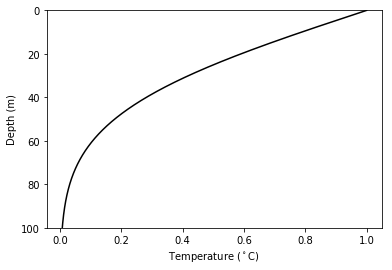

In [52]:
# Set up the problem with these constants
T0 = 0.                      # Initial Temperature
dT = 1.                      # Temperature Change
spy  = 60.*60.*24.*365.24    # (s yr-1)
t = 20*spy                   # time in years
zs = np.arange(0,100,0.1)    # a set of distances
alpha = 1.09e-6              # Thermal Diffusivity of Ice (m2 s-1)

# Run the function
T = surfacePerturbation(T0,dT,t,zs,alpha)

# Plot
plt.plot(T,zs,'k')
plt.ylim(max(zs),min(zs))
plt.ylabel('Depth (m)');
plt.xlabel('Temperature ($^\circ$C)');

### Questions

1) How do the results compare to your intuition about how long it should take for heat to diffuse into the ice?

2) If the temperature change is bigger does the perturbation propogate faster? or is it simply a scaling factor?

3) Did you try a different $\alpha$? Does the rate of propogation scale linearly with $\alpha$? Look back at the equation to help guide your answer.

### 2) Harmonic Surface Boundary

Now we are going to let the surface boundary condition change in time. If we say that the surface boundary is sinusoidal, we again can get to an analytical solution.

Surface temperature in time:
$$ T(0,t) = T_0 + T_a sin(2\pi \omega t) $$
Analytical solution:
$$ T(z,t) = T_0 + T_a exp \left ( -z \sqrt(\frac{\pi \omega}{\alpha}) \right ) sin \left (2 \pi \omega t - z \sqrt(\frac{\pi \omega}{\alpha}) \right ) $$

In [53]:
# Surface Temperature Harmonic Function
def harmonicSurface(T0,Ta,t,z,omega,alpha=alpha):
    omega *= 2.*np.pi
    alpha *= spy
    # equation 2.6-8 from Carslaw and Jaegar (1959)
    T = T0 + Ta * np.exp(-z*np.sqrt(omega/(2.*alpha))) * np.cos((omega*t)-z*np.sqrt(omega/(2*alpha)))
    return T

Same as before, we want to play around with this model to get a feel for how it works. I will give you some initial values to try out, and a plotting script, but try different numbers to get a feel for the behavior.

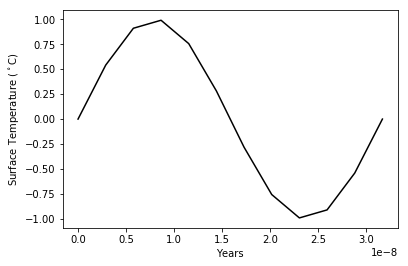

In [54]:
# Set up the problem with these constants
T0 = 0.                       # mean temperature
Ta = 1.                       # amplitude of temperature variations
ts = np.linspace(0,1,12)      # time in years (12 so that we plot one profile for each month)
zs = np.arange(0,20,0.1)      # a set of distances in meters
omega = 1.                    # period of oscillation in years

# First we should plot our surface boundary condition
plt.plot(ts/spy,T0+Ta*np.sin(2.*np.pi*omega*ts),'k');
plt.ylabel('Surface Temperature ($^\circ$C)')
plt.xlabel('Years');

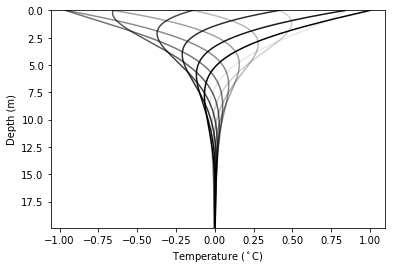

In [55]:
# Run and plot for all the times
for t in ts:
    # Run the function
    T = harmonicSurface(T0,Ta,t,zs,omega)
    # Plot
    plt.plot(T,zs,'k',alpha=(t/max(ts)))

plt.ylim(max(zs),min(zs))
plt.ylabel('Depth (m)');
plt.xlabel('Temperature ($^\circ$C)');

### Questions:

In Cuffey and Paterson (2010) chapter 9, they give us some helpful insight into the equation that we were using above: 

- The amplitude of the wave decreases as $exp(−z\sqrt(\frac{\pi \omega}{\alpha}))$. Thus, the higher the frequency,
the more rapid the attenuation with depth. 

- Temperature maxima and minima propagate at a velocity $2\sqrt(\pi \omega \alpha)$.

1) Use the points above to fill in the table from their book. Note that they use $P_\omega$ where I have simply used $\omega$. You can do this with only the equations, but try playing with the model to visualize the result.

<img src="./candpTable.png" width="400">

2) In class on Wednesday we looked at some real data. I have plotted it again below. The 'winter cold wave' persists in the ice well into the summer months. Does this agree with your results above? What was the $\Delta t$ that you got for 1yr? Is it about the same as in the data?  

<img src="./data.png" width="600">

3) Can you derive the functions that Cuffey and Paterson (2010) give from the equation that we used above? Give it a try. The term for velocity might be a bit tricky. Ask yourself when is the sine wave at a maximum or minimum for a given depth, then solve for dz/dt.

4) The 'skin depth' is that at which the amplitude of variations have been reduced to $1/e$, or 0.367, of the amplitude at the surface. Use the first bulleted point from Cuffey and Paterson (2010) above to derive the skin depth in our case (Hint: this is very similar to their value $z_5$).

### 3) Numerical Solution

Sometimes (in fact most of the time) physical problems are not as nice as those that we have posed above. Normally, we cannot come up with a nice analytical solution as in those cases. When problems are more difficult to solve, we end up using numerical methods instead. Below, we will progress from these specialized cases where the surface temperature had to be either fixed or harmonic, to a numerical solution where we can tell the surface boundary to be any temperature we would like through time. 

Note that the coding here is a little bit more involved than above, so if you want to simply skip past the next few cells and go to playing/plotting that is completely acceptable. 

In [56]:
# This is the model code, please ask questions if you are interested in this

### Create model matrix for a semi-implicit Crank-Nicholson scheme ###

from scipy import sparse
def sparseMatrix(dt,zs,u,qgeo,conductivity=2.1):
    # calculate the diffusion and advection terms
    dz = np.mean(np.gradient(zs))
    diff = alpha*(dt/(dz**2.))/2.
    adv = u*dt/(4.*dz)

    # Write the sparse matrices for left and rhs of equation, A*Tnew=B*Tlast+S
    N = len(zs)           
    A = sparse.lil_matrix((N, N))           # Create a sparse Matrix          
    A.setdiag(1.+2.*diff*np.ones(N))      # Set the diagonals       
    A.setdiag(-(diff-adv)*np.ones(N),k=1)        
    A.setdiag(-(diff+adv)*np.ones(N),k=-1)  
    B = sparse.lil_matrix((N, N))
    B.setdiag(1.-2.*diff*np.ones(N))
    B.setdiag((diff-adv)*np.ones(N),k=1)            
    B.setdiag((diff+adv)*np.ones(N),k=-1) 
    
    # Boundary Conditions
    #A[0,0] = 1+2.*diff    # Neumann at bed
    #A[0,1] = -2.*diff
    #B[0,0] = 1-2.*diff
    #B[0,1] = 2.*diff
    
    A[-1,-1] = 1+2.*diff    # Neumann at bed
    A[-1,-2] = -2.*diff
    B[-1,-1] = 1-2.*diff
    B[-1,-2] = 2.*diff
    
    #A[-1,:] = 0.        # Dirichlet at surface
    #A[-1,-1] = 1.
    #B[-1,:] = 0.
    #B[-1,-1] = 1.
    
    A[0,:] = 0.        # Dirichlet at surface
    A[0,0] = 1.
    B[0,:] = 0.
    B[0,0] = 1.

    # geothermal source
    S = np.zeros(N)
    S[-1] = -dt*qgeo/conductivity*(2./dz)*alpha
    
    return A,B,S

### Forward Model ###

from scipy.sparse.linalg import spsolve
def forwardModel(zs,ts,dt,u,BC_upper,BC_lower,IC=None):
    # Initial condition
    if IC == None:
        T = BC_upper[0]*np.ones_like(zs)
    else:
        T = IC
    if len(BC_upper) == 1:
        BC_upper = BC_upper[0]*np.ones_like(ts)
    # Set up the matrices
    A,B,S = sparseMatrix(dt*spy,zs,u/spy,BC_lower)
    # loop through times
    T_out = np.array([T])
    for i in range(len(ts)):
        T[0] = BC_upper[i]
        rhs = B*T+S
        T = spsolve(A,rhs)
        T_out = np.append(T_out,[T],axis=0)
    return T_out

Ok, the model is written. Now we can run it! Below I set up a sample problem again For now, it is exactly the same sine wave as in problem (2). Try running this to see if the answer agrees with the analytical solution. Then try a more complicated surface temperature. 

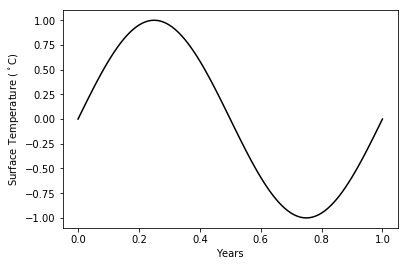

In [57]:
# Set up the problem with these constants
T0 = 0.
Ta = 1.
dt = 0.01
ts = np.arange(0,1+dt,dt)  # months of the year
zs = np.arange(0,20,0.5)      # a set of distances
omega = 2.*np.pi

Tsurface = T0 + Ta*np.sin(omega*ts)

# Again, we should plot the surface boundary condition to make sure that it is correct
plt.plot(ts,Tsurface,'k')
plt.ylabel('Surface Temperature ($^\circ$C)')
plt.xlabel('Years');

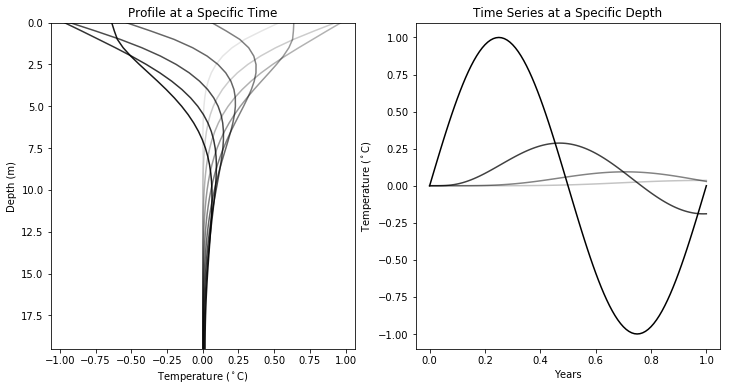

In [58]:
### Run the model and plot

# These terms can be adjusted if you get used to the model, but for now leave them alone.
# If you do come back to them, try changing both at the same time
u = 0.             # advection (m/yr)
BC_bottom = 0.0     # bottom boundary condition (W/m2)

Ts = forwardModel(zs,ts,dt,u,Tsurface,BC_bottom)

plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
# Plot for selected times
t_interval=10
maxt = 1
for i in range((len(ts)//maxt)//t_interval):
    idx = i*t_interval
    t = ts[idx]
    T = Ts[idx]
    # Plot
    plt.plot(T,zs,'k',alpha=(t*maxt/max(ts)))
    
plt.ylabel('Depth (m)');
plt.xlabel('Temperature ($^\circ$C)');
plt.ylim(max(zs),min(zs));
plt.title('Profile at a Specific Time')

ax2 = plt.subplot(122)
# Plot for selected depths
z_interval=10
for i in range(len(zs)//z_interval):
    idx = i*z_interval
    z = zs[idx]
    T = Ts[1:,idx]
    # Plot
    plt.plot(ts,T,'k',alpha=((max(zs)-z)/max(zs)))
    
plt.ylabel('Temperature ($^\circ$C)');
plt.xlabel('Years');
plt.title('Time Series at a Specific Depth');

### Questions

1) How is the numerical result different from the analytical result?

2) Try making the surface boundary condition something more complicated than a simple sine wave. How does the model respond?

3) Try overlaying several sine waves of different frequencies. Before you plot the model result, think about which frequencies will propagate further into the ice. Does the result agree with your intuition?

### Animating the result

The cells below will animate the model result that you calculated above. This is meant to help understand the result.

In [59]:
# These are functions for animating the result

# Define the initial condition for the x and y data, can just be empty arrays
def init():
    line.set_data([], [])
    return line,

# Define the animation which loops through some number of frames provided in the
# function below. At each frame the animation will chose the next set of sensor
# measurements at index[i]
def animate(i,T,ts,zs):
    x = T[i,:]
    y = zs
    line.set_data(x, y)
    time_text.set_text('Time = %.0f years' % ((ts[i]-ts[0])))
    return line, time_text

<IPython.core.display.Javascript object>


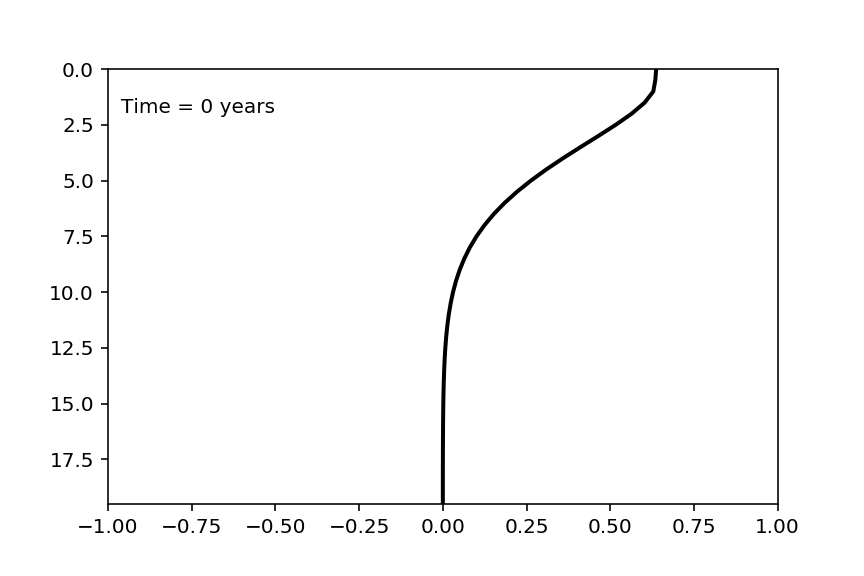

In [63]:
### Animate the solution ###

%matplotlib notebook

# Below is for plotting the result as an animation. Don't change...

fig = plt.figure()
ax = plt.axes(xlim=(np.min(Ts),np.max(Ts)), ylim=(max(zs),min(zs)))

# Define a term for the line that will be plotted and the time to print during animation
line, = ax.plot([], [],'k-',lw=2)
time_text = ax.text(0.02, 0.9, '', transform=ax.transAxes)

# Run the animation
# frames should be the length of the array so it plots every measurement (Here I have switched to only plotting one of the refreezing events)
# interval is in mSeconds and it gives a pause between plots so decrease to go faster
# blit=True says to only replot what has changed (this makes the function run faster)
import matplotlib.animation as animation
ani = animation.FuncAnimation(fig, animate, fargs=(Ts,ts,zs),init_func=init,
                                     frames=len(ts), interval=1, blit=True)